# Final Project

In [1]:
"""
Import PyTorch libraries.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random

Ankle Boot


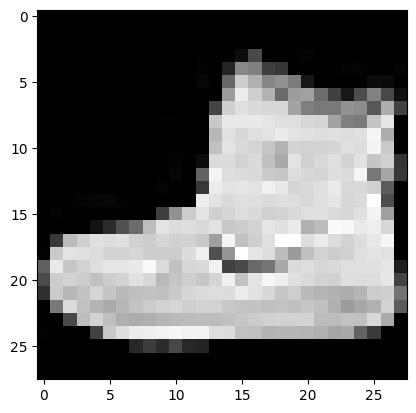

In [2]:
"""
Define the dataloader for the Fashion MNIST dataset.
"""
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(output_label(label))

In [3]:
class Sine(nn.Module):
    def __init__(self, omega_0=30):
        super().__init__()

        self.omega_0 = omega_0

    def forward(self, x):
        return torch.sin(self.omega_0 * x)

In [4]:
class SIREN(nn.Module):
    def __init__(self, input_dim=2, num_bands=3, hidden_dim=128, hidden_layers=2, output_dim=1, omega_0_initial=30, omega_0=1.0):
        super(SIREN, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.output_dim = output_dim
        self.omega_0_initial = omega_0_initial
        self.omega_0 = omega_0
        self.num_bands = num_bands

        encoded_dim = self.input_dim + 2 * self.input_dim * self.num_bands
        self.encoded_dim = encoded_dim

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(self.encoded_dim, self.hidden_dim))
        self.layers.append(Sine(self.omega_0_initial))

        for _ in range(hidden_layers):
            self.layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            self.layers.append(Sine(self.omega_0))

        self.layers.append(nn.Linear(self.hidden_dim, self.output_dim))
        self.sigmoid = nn.Sigmoid()
    
    def positional_encoding(self, coords):
        encoded = [coords]
        
        for i in range(self.num_bands):
            freq = 2.0 ** i
            encoded.append(torch.sin(coords * freq * np.pi))
            encoded.append(torch.cos(coords * freq * np.pi))
        
        return torch.cat(encoded, dim=-1)

    def forward(self, x):
        x = self.positional_encoding(x) 
        for layer in self.layers:
            x = layer(x)
        return self.sigmoid(x)

In [5]:
class VAE(nn.Module):
    def __init__(self, INN_hidden_dim=128, INN_num_bands=3, INN_hidden_layers=2):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(), 
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten()
        )

        self.mu = nn.Linear(4 * 4 * 128, 256)
        self.log_variance = nn.Linear(4 * 4 * 128, 256)

        self.INN_hidden_dim = INN_hidden_dim
        self.INN_hidden_layers = INN_hidden_layers
        self.INN_num_bands = INN_num_bands

        self.encoded_dim = 2 + 2 * 2 * self.INN_num_bands

        input_weights = self.encoded_dim * self.INN_hidden_dim + self.INN_hidden_dim
        hidden_weights = self.INN_hidden_layers * (self.INN_hidden_dim * self.INN_hidden_dim + self.INN_hidden_dim)
        output_weights = self.INN_hidden_dim * 1 + 1 

        self.total_weight = input_weights + hidden_weights + output_weights

        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),

            nn.Linear(2048, self.total_weight)
        )

    def reparameterize(self, mu, log_variance):
        sigma = torch.exp(0.5 * log_variance)
        epsilon = torch.randn_like(sigma)
        return mu + (sigma * epsilon)
    
    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_variance = self.log_variance(x)
        z = self.reparameterize(mu, log_variance)
        INN_weights = self.decoder(z)
        return INN_weights, mu, log_variance

In [6]:
"""
Initialize Hyperparameters
"""
batch_size = 68
learning_rate = 0.0001
num_epochs = 1
image_size = 28

"""
Initialize the network and the Adam optimizer
"""
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae = VAE()
vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)


"""
Generate INN weights
"""
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.'''
    if isinstance(sidelen, int):
        sidelen = dim * (sidelen,)

    if dim == 2:
        pixel_coords = np.stack(np.mgrid[:sidelen[0], :sidelen[1]], axis=-1)[None, ...].astype(np.float32)
        pixel_coords[0, :, :, 0] = pixel_coords[0, :, :, 0] / (sidelen[0] - 1)
        pixel_coords[0, :, :, 1] = pixel_coords[0, :, :, 1] / (sidelen[1] - 1)
    elif dim == 3:
        pixel_coords = np.stack(np.mgrid[:sidelen[0], :sidelen[1], :sidelen[2]], axis=-1)[None, ...].astype(np.float32)
        pixel_coords[..., 0] = pixel_coords[..., 0] / max(sidelen[0] - 1, 1)
        pixel_coords[..., 1] = pixel_coords[..., 1] / (sidelen[1] - 1)
        pixel_coords[..., 2] = pixel_coords[..., 2] / (sidelen[2] - 1)
    else:
        raise NotImplementedError('Not implemented for dim=%d' % dim)

    pixel_coords -= 0.5
    pixel_coords *= 2.
    pixel_coords = torch.Tensor(pixel_coords).view(-1, dim)
    return pixel_coords

"""
Function to create INN from weights generated by VAE decoder
"""
def create_inn_from_weights(weights, INN_hidden_dim=384, INN_hidden_layers=4, INN_num_bands=6, INN_output_dim=1, omega_0_initial=30, omega_0=1.0):    
    inn = SIREN(input_dim=2, num_bands=INN_num_bands, hidden_dim=INN_hidden_dim, 
                hidden_layers=INN_hidden_layers, output_dim=INN_output_dim, 
                omega_0_initial=omega_0_initial, omega_0=omega_0)
    
    # Add debugging for encoded_dim
    actual_input_dim = inn.layers[0].weight.shape[1]
    
    #  expected weight sizes
    input_params = actual_input_dim * INN_hidden_dim + INN_hidden_dim
    hidden_params = INN_hidden_layers * (INN_hidden_dim * INN_hidden_dim + INN_hidden_dim)
    output_params = INN_hidden_dim * INN_output_dim + INN_output_dim
    total_params = input_params + hidden_params + output_params
    
    encoded_dim = 2 + 2 * 2 * INN_num_bands
    
    start_idx = 0
    
    input_weights = weights[start_idx:start_idx + actual_input_dim * INN_hidden_dim].reshape(INN_hidden_dim, actual_input_dim)
    start_idx += actual_input_dim * INN_hidden_dim
    input_bias = weights[start_idx:start_idx + INN_hidden_dim]
    start_idx += INN_hidden_dim
    
    with torch.no_grad():
        inn.layers[0].weight.copy_(input_weights)
        inn.layers[0].bias.copy_(input_bias)
    
    for i in range(INN_hidden_layers):
        hidden_weights = weights[start_idx:start_idx + INN_hidden_dim * INN_hidden_dim].reshape(INN_hidden_dim, INN_hidden_dim)
        start_idx += INN_hidden_dim * INN_hidden_dim
        hidden_bias = weights[start_idx:start_idx + INN_hidden_dim]
        start_idx += INN_hidden_dim
        
        with torch.no_grad():
            inn.layers[2 + 2 * i].weight.copy_(hidden_weights)
            inn.layers[2 + 2 * i].bias.copy_(hidden_bias)
    
    output_weights = weights[start_idx:start_idx + INN_hidden_dim * INN_output_dim].reshape(INN_output_dim, INN_hidden_dim)
    start_idx += INN_hidden_dim * INN_output_dim
    output_bias = weights[start_idx:start_idx + INN_output_dim]
    
    with torch.no_grad():
        inn.layers[-1].weight.copy_(output_weights)
        inn.layers[-1].bias.copy_(output_bias)
    
    return inn

def create_inn_from_weights_batch(weights, INN_hidden_dim=384, INN_hidden_layers=4, INN_num_bands=6, INN_output_dim=1, omega_0_initial=30, omega_0=1.0):
    """
    Create a batch of SIREN networks from a batch of flattened weight vectors
    """
    batch_size = weights.shape[0]
    inns = []
    for i in range(batch_size):
        inn = create_inn_from_weights(
            weights[i], 
            INN_hidden_dim=INN_hidden_dim, 
            INN_hidden_layers=INN_hidden_layers,
            INN_num_bands=INN_num_bands,
            INN_output_dim=INN_output_dim, 
            omega_0_initial=omega_0_initial, 
            omega_0=omega_0
        )
        inns.append(inn)
    return inns

"""
Loss Function for VAE
"""
def loss_func(reconstructed_img, img, mu, log_variance, kl_weight=0.01):
    reconstruction_loss = F.binary_cross_entropy(reconstructed_img, img, reduction='sum')
    kl_divergence_loss = -0.5 * torch.sum(1 + log_variance - mu.pow(2) - log_variance.exp())
    return reconstruction_loss + kl_weight * kl_divergence_loss

"""
Training the VAE-INN network
"""
for epoch in range(num_epochs):
    vae.train()
    total_loss = 0
    
    for batch_idx, (img, _) in enumerate(train_loader):
        img = img.to(device)
        batch_size = img.shape[0]
        
        optimizer.zero_grad()
        
        inn_weights, mu, log_variance = vae(img)
        
        coords = get_mgrid(image_size).to(device)
    
        inns = create_inn_from_weights_batch(
            inn_weights,
            INN_hidden_dim=vae.INN_hidden_dim,
            INN_hidden_layers=vae.INN_hidden_layers,
            INN_num_bands=vae.INN_num_bands
        )
        
        reconstructed_batch = []
        for i, inn in enumerate(inns):
            inn = inn.to(device)
            with torch.no_grad():
                pixels = inn(coords) 
            
            reconstructed_image = pixels.reshape(image_size, image_size).unsqueeze(0)
            reconstructed_batch.append(reconstructed_image)
        
        reconstructed_batch = torch.cat(reconstructed_batch, dim=0)
        reconstructed_batch = reconstructed_batch.unsqueeze(1)
        
        loss = loss_func(reconstructed_batch, img, mu, log_variance) / batch_size
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 50 == 0:
            print('Epoch: [{}/{}], Train: [{}/{} ({:.0f}%)], Loss: {:.5f}'.format(
                        epoch + 1, num_epochs,
                        batch_idx * len(img), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader),
                        loss.item() / len(img)
                    ))

Epoch: [1/1], Train: [0/60000 (0%)], Loss: 11.61343


KeyboardInterrupt: 

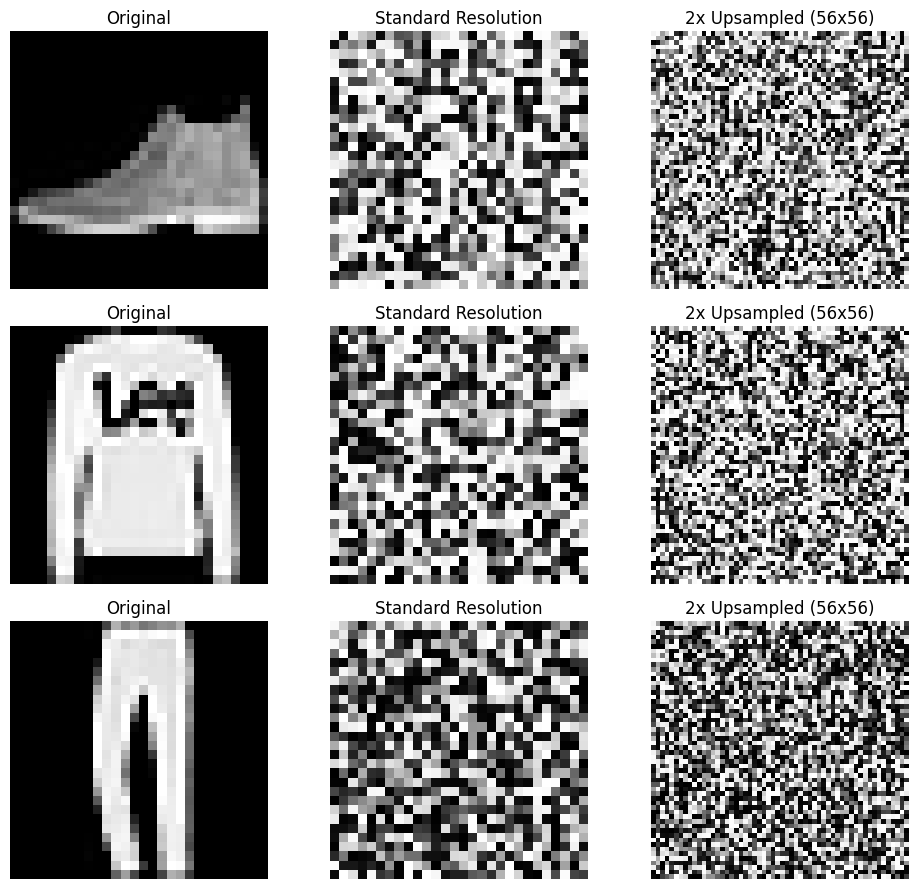

In [8]:
"""
The following part takes three images from test loader to feed into the VAE.
Shows original image and two different SIREN capabilities.
"""

import matplotlib.pyplot as plt
import numpy as np

vae.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs[:3].to(device)  
    fig, ax = plt.subplots(3, 3, figsize=(10, 9))
    
    inn_weights, mu, log_variance = vae(imgs)
    
    for i in range(3):
        img = imgs[i].cpu().squeeze(0).numpy()
        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 0].set_title('Original')
        ax[i, 0].axis('off')

        inn = create_inn_from_weights(
            inn_weights[i], 
            INN_hidden_dim=vae.INN_hidden_dim, 
            INN_hidden_layers=vae.INN_hidden_layers,
            INN_num_bands=vae.INN_num_bands,
            INN_output_dim=1,
            omega_0_initial=30,
            omega_0=1.0
        ).to(device)
        
        standard_coords = get_mgrid(image_size).to(device)
        pixels = inn(standard_coords)
        standard_image = pixels.reshape(image_size, image_size)
        std_img = standard_image.cpu().numpy()
        
        ax[i, 1].imshow(std_img, cmap='gray')
        ax[i, 1].set_title('Standard Resolution')
        ax[i, 1].axis('off')
        
        upsampled_size = image_size * 2
        upsampled_coords = get_mgrid(upsampled_size).to(device)
        upsampled_pixels = inn(upsampled_coords)
        upsampled_image = upsampled_pixels.reshape(upsampled_size, upsampled_size)
        up_img = upsampled_image.cpu().numpy()
        
        ax[i, 2].imshow(up_img, cmap='gray')
        ax[i, 2].set_title(f'2x Upsampled ({upsampled_size}x{upsampled_size})')
        ax[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('siren_capabilities.png')
    plt.show()

Using device: cpu
Coordinate shape: torch.Size([784, 34])
Coordinate min/max: -1.0 1.0
Encoded coordinate shape: torch.Size([784, 34])


Epoch 1/1:   0%|          | 2/3750 [00:00<05:07, 12.20it/s]

Batch 0/3750: Loss: 0.161701, Recon: 0.161701


Epoch 1/1:   3%|▎         | 102/3750 [00:08<05:18, 11.44it/s]

Batch 100/3750: Loss: 0.150019, Recon: 0.150019


Epoch 1/1:   5%|▌         | 203/3750 [00:16<03:10, 18.58it/s]

Batch 200/3750: Loss: 0.173555, Recon: 0.173555


Epoch 1/1:   8%|▊         | 304/3750 [00:21<02:48, 20.51it/s]

Batch 300/3750: Loss: 0.176901, Recon: 0.176901


Epoch 1/1:  11%|█         | 403/3750 [00:26<02:39, 21.03it/s]

Batch 400/3750: Loss: 0.158308, Recon: 0.158308


Epoch 1/1:  13%|█▎        | 505/3750 [00:31<02:34, 20.96it/s]

Batch 500/3750: Loss: 0.157883, Recon: 0.157883


Epoch 1/1:  16%|█▌        | 604/3750 [00:35<02:37, 20.02it/s]

Batch 600/3750: Loss: 0.156225, Recon: 0.156225


Epoch 1/1:  19%|█▊        | 702/3750 [00:40<02:30, 20.24it/s]

Batch 700/3750: Loss: 0.160167, Recon: 0.160167


Epoch 1/1:  21%|██▏       | 805/3750 [00:45<02:36, 18.79it/s]

Batch 800/3750: Loss: 0.153816, Recon: 0.153816


Epoch 1/1:  24%|██▍       | 904/3750 [00:52<02:57, 16.00it/s]

Batch 900/3750: Loss: 0.168452, Recon: 0.168452


Epoch 1/1:  27%|██▋       | 1003/3750 [00:57<02:09, 21.25it/s]

Batch 1000/3750: Loss: 0.163996, Recon: 0.163996


Epoch 1/1:  29%|██▉       | 1104/3750 [01:03<02:35, 16.98it/s]

Batch 1100/3750: Loss: 0.169841, Recon: 0.169841


Epoch 1/1:  32%|███▏      | 1203/3750 [01:09<02:26, 17.34it/s]

Batch 1200/3750: Loss: 0.161970, Recon: 0.161970


Epoch 1/1:  35%|███▍      | 1303/3750 [01:14<02:17, 17.79it/s]

Batch 1300/3750: Loss: 0.165253, Recon: 0.165253


Epoch 1/1:  37%|███▋      | 1405/3750 [01:19<01:49, 21.44it/s]

Batch 1400/3750: Loss: 0.171792, Recon: 0.171792


Epoch 1/1:  40%|████      | 1504/3750 [01:24<01:47, 20.83it/s]

Batch 1500/3750: Loss: 0.156772, Recon: 0.156772


Epoch 1/1:  43%|████▎     | 1604/3750 [01:29<01:48, 19.86it/s]

Batch 1600/3750: Loss: 0.151292, Recon: 0.151292


Epoch 1/1:  45%|████▌     | 1703/3750 [01:35<01:49, 18.73it/s]

Batch 1700/3750: Loss: 0.166345, Recon: 0.166345


Epoch 1/1:  48%|████▊     | 1805/3750 [01:40<01:35, 20.36it/s]

Batch 1800/3750: Loss: 0.166865, Recon: 0.166865


Epoch 1/1:  51%|█████     | 1903/3750 [01:44<01:28, 20.96it/s]

Batch 1900/3750: Loss: 0.174835, Recon: 0.174835


Epoch 1/1:  53%|█████▎    | 2004/3750 [01:49<01:22, 21.27it/s]

Batch 2000/3750: Loss: 0.179913, Recon: 0.179913


Epoch 1/1:  56%|█████▌    | 2105/3750 [01:54<01:21, 20.19it/s]

Batch 2100/3750: Loss: 0.169694, Recon: 0.169694


Epoch 1/1:  59%|█████▉    | 2205/3750 [01:59<01:14, 20.68it/s]

Batch 2200/3750: Loss: 0.169520, Recon: 0.169520


Epoch 1/1:  61%|██████▏   | 2304/3750 [02:04<01:09, 20.88it/s]

Batch 2300/3750: Loss: 0.165718, Recon: 0.165718


Epoch 1/1:  64%|██████▍   | 2403/3750 [02:09<01:05, 20.70it/s]

Batch 2400/3750: Loss: 0.167273, Recon: 0.167273


Epoch 1/1:  67%|██████▋   | 2505/3750 [02:14<00:58, 21.23it/s]

Batch 2500/3750: Loss: 0.168533, Recon: 0.168533


Epoch 1/1:  69%|██████▉   | 2604/3750 [02:18<00:54, 21.13it/s]

Batch 2600/3750: Loss: 0.165044, Recon: 0.165044


Epoch 1/1:  72%|███████▏  | 2703/3750 [02:23<00:49, 21.35it/s]

Batch 2700/3750: Loss: 0.173134, Recon: 0.173134


Epoch 1/1:  75%|███████▍  | 2805/3750 [02:28<00:47, 20.07it/s]

Batch 2800/3750: Loss: 0.164641, Recon: 0.164641


Epoch 1/1:  77%|███████▋  | 2903/3750 [02:33<00:41, 20.26it/s]

Batch 2900/3750: Loss: 0.166172, Recon: 0.166172


Epoch 1/1:  80%|████████  | 3004/3750 [02:38<00:35, 21.21it/s]

Batch 3000/3750: Loss: 0.152275, Recon: 0.152275


Epoch 1/1:  83%|████████▎ | 3103/3750 [02:43<00:30, 21.01it/s]

Batch 3100/3750: Loss: 0.157655, Recon: 0.157655


Epoch 1/1:  85%|████████▌ | 3205/3750 [02:48<00:25, 21.20it/s]

Batch 3200/3750: Loss: 0.171302, Recon: 0.171302


Epoch 1/1:  88%|████████▊ | 3304/3750 [02:53<00:21, 20.71it/s]

Batch 3300/3750: Loss: 0.160283, Recon: 0.160283


Epoch 1/1:  91%|█████████ | 3404/3750 [02:57<00:17, 20.25it/s]

Batch 3400/3750: Loss: 0.173895, Recon: 0.173895


Epoch 1/1:  93%|█████████▎| 3505/3750 [03:03<00:12, 20.30it/s]

Batch 3500/3750: Loss: 0.167728, Recon: 0.167728


Epoch 1/1:  96%|█████████▌| 3603/3750 [03:09<00:07, 20.23it/s]

Batch 3600/3750: Loss: 0.170103, Recon: 0.170103


Epoch 1/1:  99%|█████████▉| 3704/3750 [03:15<00:02, 20.48it/s]

Batch 3700/3750: Loss: 0.167345, Recon: 0.167345


Epoch 1/1: 100%|██████████| 3750/3750 [03:17<00:00, 18.99it/s]


Epoch [1/1] Loss: 0.164933, Recon: 0.164933, 
Training complete!


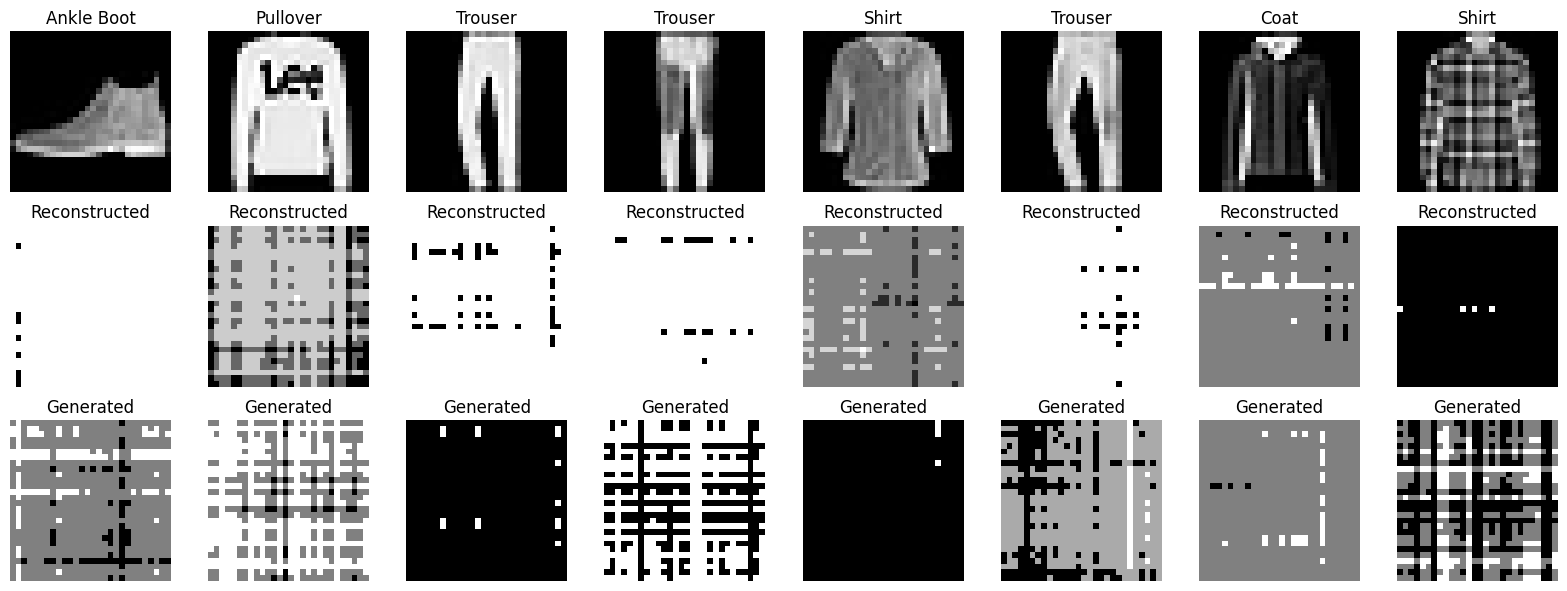

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=transform)

batch_size = 16  
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

def positional_encoding(coords, num_bands=8):
    """Apply positional encoding to coordinates with multiple frequency bands."""
    pos_enc = [coords]
    for i in range(num_bands):
        freq = 2.0 ** i
        pos_enc.append(torch.sin(coords * freq * np.pi))
        pos_enc.append(torch.cos(coords * freq * np.pi))
    return torch.cat(pos_enc, dim=-1)

def get_mgrid(sidelen, dim=2, num_bands=8):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.'''
    if isinstance(sidelen, int):
        sidelen = dim * (sidelen,)
    coords = [torch.linspace(-1, 1, s) for s in sidelen]
    mesh_coords = torch.meshgrid(*coords, indexing='ij')  
    coords = torch.stack(mesh_coords, dim=-1).reshape(-1, dim)
    return positional_encoding(coords, num_bands)

class SIREN(nn.Module):
    def __init__(self, input_dim=2+2*2*8, hidden_dim=256, hidden_layers=3, output_dim=1, first_omega=1.0, hidden_omega=10.0):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.output_dim = output_dim
        self.first_omega = first_omega
        self.hidden_omega = hidden_omega

        self.first_layer = nn.Linear(input_dim, hidden_dim)
        with torch.no_grad():

            self.first_layer.weight.uniform_(-1/input_dim, 1/input_dim)
            self.first_layer.bias.uniform_(-1/input_dim, 1/input_dim)
        
        self.hidden_layers_list = nn.ModuleList()
        for _ in range(hidden_layers):
            layer = nn.Linear(hidden_dim, hidden_dim)
            with torch.no_grad():

                layer.weight.uniform_(-np.sqrt(6/hidden_dim)/hidden_omega, 
                                      np.sqrt(6/hidden_dim)/hidden_omega)
                layer.bias.uniform_(-np.sqrt(6/hidden_dim)/hidden_omega, 
                                    np.sqrt(6/hidden_dim)/hidden_omega)
            self.hidden_layers_list.append(layer)
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        with torch.no_grad():

            self.output_layer.weight.uniform_(-np.sqrt(6/hidden_dim)/hidden_omega, 
                                              np.sqrt(6/hidden_dim)/hidden_omega)
            self.output_layer.bias.uniform_(-1, 1)
    
    def forward(self, x):
        x = torch.sin(self.first_omega * self.first_layer(x))
        for layer in self.hidden_layers_list:
            x = torch.sin(self.hidden_omega * layer(x))

        return torch.sigmoid(self.output_layer(x))
    
    def set_weights_vector(self, weights_vector):
        """Set all weights from a flattened vector"""
        start_idx = 0
        

        w_size = self.first_layer.weight.numel()
        self.first_layer.weight.data = weights_vector[start_idx:start_idx+w_size].view(self.first_layer.weight.shape)
        start_idx += w_size
        
        b_size = self.first_layer.bias.numel()
        self.first_layer.bias.data = weights_vector[start_idx:start_idx+b_size].view(self.first_layer.bias.shape)
        start_idx += b_size
        

        for layer in self.hidden_layers_list:
            w_size = layer.weight.numel()
            layer.weight.data = weights_vector[start_idx:start_idx+w_size].view(layer.weight.shape)
            start_idx += w_size
            
            b_size = layer.bias.numel()
            layer.bias.data = weights_vector[start_idx:start_idx+b_size].view(layer.bias.shape)
            start_idx += b_size
        

        w_size = self.output_layer.weight.numel()
        self.output_layer.weight.data = weights_vector[start_idx:start_idx+w_size].view(self.output_layer.weight.shape)
        start_idx += w_size
        
        b_size = self.output_layer.bias.numel()
        self.output_layer.bias.data = weights_vector[start_idx:start_idx+b_size].view(self.output_layer.bias.shape)
    
    @staticmethod
    def calc_total_weights(input_dim, hidden_dim, hidden_layers, output_dim):
        """Calculate the total number of weights in the SIREN"""
        total = input_dim * hidden_dim + hidden_dim
        
        total += hidden_layers * (hidden_dim * hidden_dim + hidden_dim)
        
        total += hidden_dim * output_dim + output_dim
        
        return total

class VAE(nn.Module):
    def __init__(self, z_dim=64, siren_config=None):
        super().__init__()
        self.z_dim = z_dim
        
        # Default SIREN config
        self.siren_config = {
            'input_dim': 2 + 2*2*8,  
            'hidden_dim': 128,       
            'hidden_layers': 3,       
            'output_dim': 1
        }
        
        # Update config if provided
        if siren_config is not None:
            self.siren_config.update(siren_config)
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),             # 28x28 -> 14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),            # 14x14 -> 7x7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),           # 7x7 -> 7x7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        

        self.fc_mu = nn.Linear(512, z_dim)
        self.fc_logvar = nn.Linear(512, z_dim)
        

        total_weights = SIREN.calc_total_weights(
            input_dim=self.siren_config['input_dim'],
            hidden_dim=self.siren_config['hidden_dim'],
            hidden_layers=self.siren_config['hidden_layers'],
            output_dim=self.siren_config['output_dim']
        )
        

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, total_weights) 
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, -4, 4)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    # Modify your VAE's decode method
    def decode(self, z):
        raw_weights = self.decoder(z)
        
        # Split and scale weights for different SIREN layers
        weights_list = []
        start_idx = 0
        
        # First layer weights - needs uniform(-1/in_dim, 1/in_dim)
        in_dim = self.siren_config['input_dim']
        first_w_size = in_dim * self.siren_config['hidden_dim']
        first_b_size = self.siren_config['hidden_dim']
        
        first_w = raw_weights[:, start_idx:start_idx+first_w_size].view(-1, self.siren_config['hidden_dim'], in_dim)
        start_idx += first_w_size
        first_w = torch.tanh(first_w) * (1.0/in_dim)  # Scale to proper range
        weights_list.append(first_w.reshape(-1, first_w_size))
        
        first_b = raw_weights[:, start_idx:start_idx+first_b_size]
        start_idx += first_b_size
        first_b = torch.tanh(first_b) * (1.0/in_dim)  # Scale to proper range
        weights_list.append(first_b)
        
        # Hidden layers - needs scaled by sqrt(6/hidden_dim)/omega
        hidden_dim = self.siren_config['hidden_dim']
        hidden_omega = 30.0
        scale_factor = np.sqrt(6/hidden_dim)/hidden_omega
        
        for _ in range(self.siren_config['hidden_layers']):
            hidden_w_size = hidden_dim * hidden_dim
            hidden_w = raw_weights[:, start_idx:start_idx+hidden_w_size].view(-1, hidden_dim, hidden_dim)
            start_idx += hidden_w_size
            hidden_w = torch.tanh(hidden_w) * scale_factor
            weights_list.append(hidden_w.reshape(-1, hidden_w_size))
            
            hidden_b_size = hidden_dim
            hidden_b = raw_weights[:, start_idx:start_idx+hidden_b_size]
            start_idx += hidden_b_size
            hidden_b = torch.tanh(hidden_b) * scale_factor
            weights_list.append(hidden_b)
        
        # Output layer
        out_dim = self.siren_config['output_dim']
        out_w_size = hidden_dim * out_dim
        out_w = raw_weights[:, start_idx:start_idx+out_w_size].view(-1, out_dim, hidden_dim)
        start_idx += out_w_size
        out_w = torch.tanh(out_w) * scale_factor
        weights_list.append(out_w.reshape(-1, out_w_size))
        
        out_b_size = out_dim
        out_b = raw_weights[:, start_idx:start_idx+out_b_size]
        out_b = torch.tanh(out_b)  # Range (-1, 1) is fine for output bias
        weights_list.append(out_b)
        
        # Concatenate all scaled weights
        return torch.cat(weights_list, dim=1)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def train(num_epochs=10, save_interval=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    

    num_bands = 8
    siren_config = {
        'input_dim': 2 + 2*2*num_bands,
        'hidden_dim': 128, 
        'hidden_layers': 3, 
        'output_dim': 1,
    }
    

    vae = VAE(z_dim=64, siren_config=siren_config).to(device) 
    siren = SIREN(
        input_dim=siren_config['input_dim'],
        hidden_dim=siren_config['hidden_dim'],
        hidden_layers=siren_config['hidden_layers'],
        output_dim=siren_config['output_dim']
    ).to(device)
    
    optimizer = torch.optim.Adam(vae.parameters(), lr=0.0005)
    
    coords = get_mgrid(28, num_bands=num_bands).to(device)

    with torch.no_grad():
        print("Coordinate shape:", coords.shape)
        print("Coordinate min/max:", coords[:, 0].min().item(), coords[:, 0].max().item())
        print("Encoded coordinate shape:", coords.shape)
        
        # Visualize the coordinate grid to make sure it's correct
        coord_grid = coords[:, :2].reshape(28, 28, 2)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(coord_grid[:, :, 0].cpu())
        plt.title("X coordinates")
        plt.subplot(1, 2, 2)
        plt.imshow(coord_grid[:, :, 1].cpu())
        plt.title("Y coordinates")
        plt.savefig("coordinate_grid.png")
        plt.close()
    
    example_data = next(iter(test_loader))
    example_images = example_data[0][:8].to(device)
    
    best_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        vae.train()
        total_loss = 0
        total_recon_loss = 0
        total_kl_loss = 0
        
        for batch_idx, (images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            images = images.to(device)
            batch_size = images.size(0)
            
            optimizer.zero_grad()
            
            siren_weights_batch, mu, logvar = vae(images)
            
            reconstruction_loss = 0
            
            reconstructed_images = []
            for j in range(batch_size):
                siren.set_weights_vector(siren_weights_batch[j])
                
                reconstructed_image = siren(coords).reshape(1, 1, 28, 28)
                reconstructed_images.append(reconstructed_image)
            
            reconstructed_batch = torch.cat(reconstructed_images, dim=0)
            
            reconstruction_loss = F.mse_loss(reconstructed_batch, images)
            
            loss = reconstruction_loss
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            

            optimizer.step()
            
            total_loss += loss.item()
            total_recon_loss += reconstruction_loss.item()
            

            if batch_idx % 100 == 0:
                print(f"Batch {batch_idx}/{len(train_loader)}: "
                      f"Loss: {loss.item():.6f}, "
                      f"Recon: {reconstruction_loss.item():.6f}")
        

        avg_loss = total_loss / len(train_loader)
        avg_recon = total_recon_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss: {avg_loss:.6f}, "
              f"Recon: {avg_recon:.6f}, ")
        

        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0

            torch.save({
                'vae_state_dict': vae.state_dict(),
                'siren_config': siren_config,
                'epoch': epoch,
                'loss': avg_loss
            }, 'best_vae_siren_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        if epoch % save_interval == 0:
            with torch.no_grad():
                vae.eval()
                

                test_recon_images = []
                for i in range(example_images.size(0)):
                    # Encode and decode
                    mu, logvar = vae.encode(example_images[i:i+1])
                    z = vae.reparameterize(mu, logvar)
                    siren_weights = vae.decode(z)
                    
                    # Set weights and get reconstruction
                    siren.set_weights_vector(siren_weights.squeeze(0))
                    recon_image = siren(coords).reshape(1, 28, 28)
                    test_recon_images.append(recon_image)
                
                # Stack the images
                test_recon_images = torch.cat(test_recon_images, dim=0)
                
                # Generate random samples
                z = torch.randn(8, vae.z_dim, device=device)
                generated_images = []
                for i in range(z.size(0)):
                    siren_weights = vae.decode(z[i:i+1])
                    siren.set_weights_vector(siren_weights.squeeze(0))
                    gen_image = siren(coords).reshape(1, 28, 28)
                    generated_images.append(gen_image)
                

                generated_images = torch.cat(generated_images, dim=0)
                

                plt.figure(figsize=(12, 8))
                

                for i in range(8):
                    plt.subplot(3, 8, i + 1)
                    plt.imshow(example_images[i].cpu().squeeze(), cmap='gray')
                    plt.axis('off')
                    plt.title("Original")
                
                for i in range(8):
                    plt.subplot(3, 8, i + 9)
                    plt.imshow(test_recon_images[i].cpu().squeeze(), cmap='gray')
                    plt.axis('off')
                    plt.title("Reconstructed")
                
                # Plot generated images
                for i in range(8):
                    plt.subplot(3, 8, i + 17)
                    plt.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
                    plt.axis('off')
                    plt.title("Generated")
                
                plt.suptitle(f"Epoch {epoch+1}")
                plt.tight_layout()
                plt.savefig(f"vae_siren_epoch_{epoch+1}.png")
                plt.close()
    
    print("Training complete!")
    return vae, siren

def evaluate_model(model_path='best_vae_siren_model.pt'):
    # Load model
    checkpoint = torch.load(model_path)
    siren_config = checkpoint['siren_config']
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    vae = VAE(z_dim=64, siren_config=siren_config).to(device)
    vae.load_state_dict(checkpoint['vae_state_dict'])
    
    siren = SIREN(
        input_dim=siren_config['input_dim'],
        hidden_dim=siren_config['hidden_dim'],
        hidden_layers=siren_config['hidden_layers'],
        output_dim=siren_config['output_dim']
    ).to(device)
    
    coords = get_mgrid(28, num_bands=8).to(device)
    
    example_data = next(iter(test_loader))
    test_images = example_data[0][:8].to(device)
    test_labels = example_data[1][:8]
    
    vae.eval()
    with torch.no_grad():
        reconstructed_images = []
        for i in range(test_images.size(0)):
            mu, logvar = vae.encode(test_images[i:i+1])
            z = vae.reparameterize(mu, logvar)
            siren_weights = vae.decode(z)
            
            siren.set_weights_vector(siren_weights.squeeze(0))
            recon_image = siren(coords).reshape(1, 28, 28)
            reconstructed_images.append(recon_image)
        
        reconstructed_images = torch.cat(reconstructed_images, dim=0)
        
        z = torch.randn(8, vae.z_dim, device=device)
        generated_images = []
        for i in range(z.size(0)):
            siren_weights = vae.decode(z[i:i+1])
            siren.set_weights_vector(siren_weights.squeeze(0))
            gen_image = siren(coords).reshape(1, 28, 28)
            generated_images.append(gen_image)
        
        generated_images = torch.cat(generated_images, dim=0)
    
    fig, axs = plt.subplots(3, 8, figsize=(16, 6))
    
    for i in range(8):
        # Original
        axs[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
        axs[0, i].set_title(f"{class_names[test_labels[i]]}")
        axs[0, i].axis('off')
        
        # Reconstructed
        axs[1, i].imshow(reconstructed_images[i].cpu().squeeze(), cmap='gray')
        axs[1, i].set_title("Reconstructed")
        axs[1, i].axis('off')
        
        # Generated
        axs[2, i].imshow(generated_images[i].cpu().squeeze(), cmap='gray')
        axs[2, i].set_title("Generated")
        axs[2, i].axis('off')
    
    plt.tight_layout()
    plt.savefig("evaluation_results.png")
    plt.show()
    
    return vae, siren

if __name__ == "__main__":
    vae, siren = train(num_epochs=1, save_interval=1)
    evaluate_model()

Using device: cpu
Step 1: Fitting SIRENs to images...
Using device: cpu
Total SIREN weights: 54145
Fitting first SIREN...
Epoch 100/1000, Loss: 0.042416
Epoch 200/1000, Loss: 0.019771
Epoch 300/1000, Loss: 0.009299
Epoch 400/1000, Loss: 0.005159
Epoch 500/1000, Loss: 0.003239
Epoch 600/1000, Loss: 0.001936
Epoch 700/1000, Loss: 0.001197
Epoch 800/1000, Loss: 0.000819
Epoch 900/1000, Loss: 0.000599
Epoch 1000/1000, Loss: 0.000459


Fitting SIRENs: 100%|██████████| 100/100 [01:43<00:00,  1.04s/it]

Collected weights for 100 SIRENs, shape: torch.Size([100, 54145])
Visualizing some fitted SIRENs...


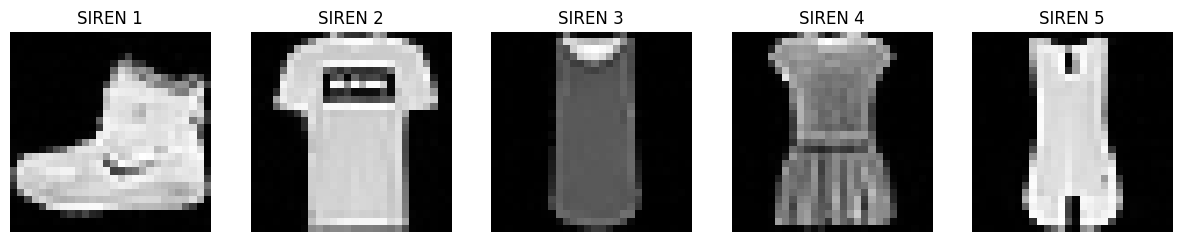

Step 2: Training diffusion model on SIREN weights...


Epoch 1/100: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Batch 0/1: Loss: 0.333628


Epoch 2/100: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Batch 0/1: Loss: 0.302307


Epoch 3/100: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Batch 0/1: Loss: 0.271315


Epoch 4/100: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Batch 0/1: Loss: 0.240441


Epoch 5/100: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Batch 0/1: Loss: 0.211930


Epoch 6/100: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Batch 0/1: Loss: 0.186598


Epoch 7/100: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Batch 0/1: Loss: 0.162950


Epoch 8/100: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Batch 0/1: Loss: 0.142061


Epoch 9/100: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Batch 0/1: Loss: 0.123057


Epoch 10/100: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Batch 0/1: Loss: 0.106438


Epoch 11/100: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Batch 0/1: Loss: 0.092278


Epoch 12/100: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Batch 0/1: Loss: 0.080170


Epoch 13/100: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Batch 0/1: Loss: 0.070617


Epoch 14/100: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


Batch 0/1: Loss: 0.061648


Epoch 15/100: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Batch 0/1: Loss: 0.053893


Epoch 16/100: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Batch 0/1: Loss: 0.047373


Epoch 17/100: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Batch 0/1: Loss: 0.042154


Epoch 18/100: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Batch 0/1: Loss: 0.038044


Epoch 19/100: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Batch 0/1: Loss: 0.034202


Epoch 20/100: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Batch 0/1: Loss: 0.030850


Epoch 21/100: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


Batch 0/1: Loss: 0.029233


Epoch 22/100: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Batch 0/1: Loss: 0.026568


Epoch 23/100: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


Batch 0/1: Loss: 0.024948


Epoch 24/100: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Batch 0/1: Loss: 0.023412


Epoch 25/100: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Batch 0/1: Loss: 0.021947


Epoch 26/100: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Batch 0/1: Loss: 0.020572


Epoch 27/100: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Batch 0/1: Loss: 0.019387


Epoch 28/100: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Batch 0/1: Loss: 0.018756


Epoch 29/100: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Batch 0/1: Loss: 0.017888


Epoch 30/100: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Batch 0/1: Loss: 0.017274


Epoch 31/100: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Batch 0/1: Loss: 0.016343


Epoch 32/100: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Batch 0/1: Loss: 0.015602


Epoch 33/100: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Batch 0/1: Loss: 0.015140


Epoch 34/100: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Batch 0/1: Loss: 0.014564


Epoch 35/100: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Batch 0/1: Loss: 0.014071


Epoch 36/100: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Batch 0/1: Loss: 0.013580


Epoch 37/100: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Batch 0/1: Loss: 0.013194


Epoch 38/100: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Batch 0/1: Loss: 0.012701


Epoch 39/100: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Batch 0/1: Loss: 0.012477


Epoch 40/100: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Batch 0/1: Loss: 0.012069


Epoch 41/100: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Batch 0/1: Loss: 0.011634


Epoch 42/100: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Batch 0/1: Loss: 0.011488


Epoch 43/100: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Batch 0/1: Loss: 0.011214


Epoch 44/100: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


Batch 0/1: Loss: 0.010917


Epoch 45/100: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Batch 0/1: Loss: 0.010851


Epoch 46/100: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Batch 0/1: Loss: 0.010461


Epoch 47/100: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Batch 0/1: Loss: 0.010447


Epoch 48/100: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Batch 0/1: Loss: 0.010296


Epoch 49/100: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Batch 0/1: Loss: 0.009985


Epoch 50/100: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Batch 0/1: Loss: 0.009765


Epoch 51/100: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Batch 0/1: Loss: 0.009779


Epoch 52/100: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Batch 0/1: Loss: 0.009692


Epoch 53/100: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Batch 0/1: Loss: 0.009590


Epoch 54/100: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Batch 0/1: Loss: 0.009470


Epoch 55/100: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Batch 0/1: Loss: 0.009245


Epoch 56/100: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Batch 0/1: Loss: 0.009089


Epoch 57/100: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Batch 0/1: Loss: 0.008936


Epoch 58/100: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


Batch 0/1: Loss: 0.008865


Epoch 59/100: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Batch 0/1: Loss: 0.008790


Epoch 60/100: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Batch 0/1: Loss: 0.008834


Epoch 61/100: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Batch 0/1: Loss: 0.008519


Epoch 62/100: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Batch 0/1: Loss: 0.008646


Epoch 63/100: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Batch 0/1: Loss: 0.008534


Epoch 64/100: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Batch 0/1: Loss: 0.008572


Epoch 65/100: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Batch 0/1: Loss: 0.008449


Epoch 66/100: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Batch 0/1: Loss: 0.008272


Epoch 67/100: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


Batch 0/1: Loss: 0.008253


Epoch 68/100: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Batch 0/1: Loss: 0.008332


Epoch 69/100: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Batch 0/1: Loss: 0.008201


Epoch 70/100: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Batch 0/1: Loss: 0.008032


Epoch 71/100: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Batch 0/1: Loss: 0.008171


Epoch 72/100: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Batch 0/1: Loss: 0.008108


Epoch 73/100: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Batch 0/1: Loss: 0.008100


Epoch 74/100: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Batch 0/1: Loss: 0.007874


Epoch 75/100: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Batch 0/1: Loss: 0.007949


Epoch 76/100: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Batch 0/1: Loss: 0.007858


Epoch 77/100: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Batch 0/1: Loss: 0.008010


Epoch 78/100: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Batch 0/1: Loss: 0.007697


Epoch 79/100: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Batch 0/1: Loss: 0.007763


Epoch 80/100: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Batch 0/1: Loss: 0.007799


Epoch 81/100: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Batch 0/1: Loss: 0.007652


Epoch 82/100: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Batch 0/1: Loss: 0.007620


Epoch 83/100: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Batch 0/1: Loss: 0.007571


Epoch 84/100: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Batch 0/1: Loss: 0.007696


Epoch 85/100: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Batch 0/1: Loss: 0.007505


Epoch 86/100: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Batch 0/1: Loss: 0.007554


Epoch 87/100: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Batch 0/1: Loss: 0.007489


Epoch 88/100: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Batch 0/1: Loss: 0.007507


Epoch 89/100: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Batch 0/1: Loss: 0.007421


Epoch 90/100: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Batch 0/1: Loss: 0.007537


Epoch 91/100: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Batch 0/1: Loss: 0.007453


Epoch 92/100: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Batch 0/1: Loss: 0.007442


Epoch 93/100: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Batch 0/1: Loss: 0.007449


Epoch 94/100: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Batch 0/1: Loss: 0.007282


Epoch 95/100: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Batch 0/1: Loss: 0.007273


Epoch 96/100: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Batch 0/1: Loss: 0.007252


Epoch 97/100: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Batch 0/1: Loss: 0.007170


Epoch 98/100: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Batch 0/1: Loss: 0.007170


Epoch 99/100: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Batch 0/1: Loss: 0.007183


Epoch 100/100: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Batch 0/1: Loss: 0.007145
Step 3: Generating samples...
Generating 5 samples...


Sampling: 100%|██████████| 100/100 [00:01<00:00, 56.04it/s]


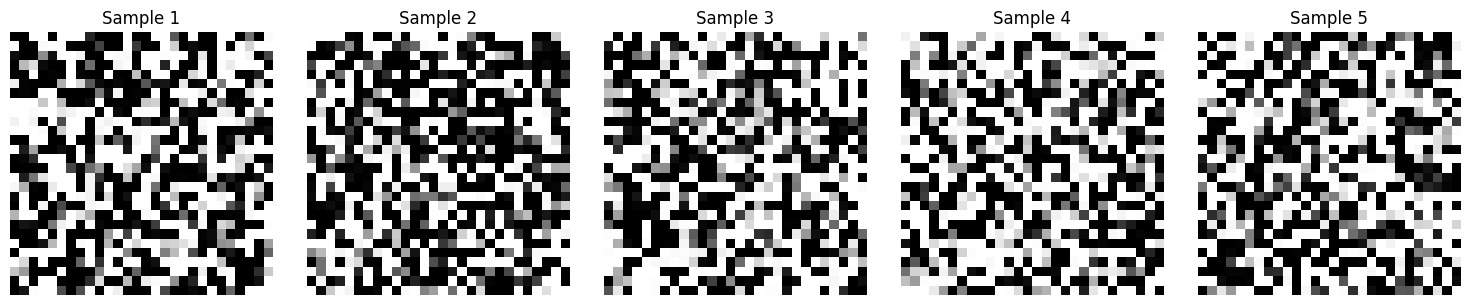

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

# Data Loading
transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=transform)

batch_size = 16  
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Positional encoding functions
def positional_encoding(coords, num_bands=8):
    """Apply positional encoding to coordinates with multiple frequency bands."""
    pos_enc = [coords]
    for i in range(num_bands):
        freq = 2.0 ** i
        pos_enc.append(torch.sin(coords * freq * np.pi))
        pos_enc.append(torch.cos(coords * freq * np.pi))
    return torch.cat(pos_enc, dim=-1)

def get_mgrid(sidelen, dim=2, num_bands=8):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.'''
    if isinstance(sidelen, int):
        sidelen = dim * (sidelen,)
    coords = [torch.linspace(-1, 1, s) for s in sidelen]
    mesh_coords = torch.meshgrid(*coords, indexing='ij')  
    coords = torch.stack(mesh_coords, dim=-1).reshape(-1, dim)
    return positional_encoding(coords, num_bands)

# SIREN Model
class SIREN(nn.Module):
    def __init__(self, input_dim=2+2*2*8, hidden_dim=256, hidden_layers=3, output_dim=1, first_omega=1.0, hidden_omega=10.0):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.output_dim = output_dim
        self.first_omega = first_omega
        self.hidden_omega = hidden_omega

        self.first_layer = nn.Linear(input_dim, hidden_dim)
        with torch.no_grad():
            self.first_layer.weight.uniform_(-1/input_dim, 1/input_dim)
            self.first_layer.bias.uniform_(-1/input_dim, 1/input_dim)
        
        self.hidden_layers_list = nn.ModuleList()
        for _ in range(hidden_layers):
            layer = nn.Linear(hidden_dim, hidden_dim)
            with torch.no_grad():
                layer.weight.uniform_(-np.sqrt(6/hidden_dim)/hidden_omega, 
                                      np.sqrt(6/hidden_dim)/hidden_omega)
                layer.bias.uniform_(-np.sqrt(6/hidden_dim)/hidden_omega, 
                                    np.sqrt(6/hidden_dim)/hidden_omega)
            self.hidden_layers_list.append(layer)
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        with torch.no_grad():
            self.output_layer.weight.uniform_(-np.sqrt(6/hidden_dim)/hidden_omega, 
                                              np.sqrt(6/hidden_dim)/hidden_omega)
            self.output_layer.bias.uniform_(-1, 1)
    
    def forward(self, x):
        x = torch.sin(self.first_omega * self.first_layer(x))
        for layer in self.hidden_layers_list:
            x = torch.sin(self.hidden_omega * layer(x))

        return torch.sigmoid(self.output_layer(x))
    
    def set_weights_vector(self, weights_vector):
        """Set all weights from a flattened vector"""
        start_idx = 0
        
        w_size = self.first_layer.weight.numel()
        self.first_layer.weight.data = weights_vector[start_idx:start_idx+w_size].view(self.first_layer.weight.shape)
        start_idx += w_size
        
        b_size = self.first_layer.bias.numel()
        self.first_layer.bias.data = weights_vector[start_idx:start_idx+b_size].view(self.first_layer.bias.shape)
        start_idx += b_size
        
        for layer in self.hidden_layers_list:
            w_size = layer.weight.numel()
            layer.weight.data = weights_vector[start_idx:start_idx+w_size].view(layer.weight.shape)
            start_idx += w_size
            
            b_size = layer.bias.numel()
            layer.bias.data = weights_vector[start_idx:start_idx+b_size].view(layer.bias.shape)
            start_idx += b_size
        
        w_size = self.output_layer.weight.numel()
        self.output_layer.weight.data = weights_vector[start_idx:start_idx+w_size].view(self.output_layer.weight.shape)
        start_idx += w_size
        
        b_size = self.output_layer.bias.numel()
        self.output_layer.bias.data = weights_vector[start_idx:start_idx+b_size].view(self.output_layer.bias.shape)
    
    @staticmethod
    def calc_total_weights(input_dim, hidden_dim, hidden_layers, output_dim):
        """Calculate the total number of weights in the SIREN"""
        total = input_dim * hidden_dim + hidden_dim  # First layer
        total += hidden_layers * (hidden_dim * hidden_dim + hidden_dim)  # Hidden layers
        total += hidden_dim * output_dim + output_dim  # Output layer
        return total

    def get_weights_vector(self):
        """Get all weights as a flattened vector"""
        weights = []
        weights.append(self.first_layer.weight.data.flatten())
        weights.append(self.first_layer.bias.data.flatten())
        
        for layer in self.hidden_layers_list:
            weights.append(layer.weight.data.flatten())
            weights.append(layer.bias.data.flatten())
        
        weights.append(self.output_layer.weight.data.flatten())
        weights.append(self.output_layer.bias.data.flatten())
        
        return torch.cat(weights, dim=0)

# Time embedding for diffusion model
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((torch.sin(embeddings), torch.cos(embeddings)), dim=-1)
        return embeddings

# Modified Diffusion model - Transformer-based following HyperDiffusion approach
class TransformerDiffusion(nn.Module):
    def __init__(self, weight_dim, n_heads=8, n_layers=6, hidden_dim=512, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Time embedding
        self.time_dim = hidden_dim
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Input projection
        self.input_projection = nn.Linear(weight_dim, hidden_dim)
        
        # Position encoding
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, 
            nhead=n_heads, 
            dim_feedforward=hidden_dim*4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, n_layers)
        
        # Output projection
        self.output_projection = nn.Linear(hidden_dim, weight_dim)
    
    def forward(self, x, timestep):
        # Get time embedding and reshape it
        time_emb = self.time_mlp(timestep)  # [batch_size, hidden_dim]
        time_emb = time_emb.unsqueeze(1)   # [batch_size, 1, hidden_dim]
        
        # Project input weights to hidden dimension
        x = self.input_projection(x).unsqueeze(1)  # [batch_size, 1, hidden_dim]
        
        # Add time embedding and positional encoding
        x = x + time_emb + self.pos_embedding
        
        # Pass through transformer
        x = self.transformer(x)
        
        # Project back to weight space
        return self.output_projection(x.squeeze(1))

class DiffusionModel:
    def __init__(self, model, total_weights, device, beta_start=1e-4, beta_end=0.02, timesteps=1000):
        self.model = model
        self.total_weights = total_weights
        self.device = device
        self.timesteps = timesteps
        
        # Define beta schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        
        # Calculations for diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        
        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)
    
    def q_sample(self, x_start, t, noise=None):
        """Forward diffusion process: q(x_t | x_0)"""
        if noise is None:
            noise = torch.randn_like(x_start)
            
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].reshape(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1)
        
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    def p_losses(self, x_start, t, noise=None):
        """Training loss for diffusion model"""
        if noise is None:
            noise = torch.randn_like(x_start)
            
        # Get noisy weights at timestep t
        x_noisy = self.q_sample(x_start, t, noise)
        
        # Predict the denoised weights directly
        pred_x0 = self.model(x_noisy, t)
        
        # Loss is MSE between true weights and predicted denoised weights
        loss = F.mse_loss(pred_x0, x_start)
        
        return loss
    
    def p_sample(self, x, t, t_index):
        """Sample from p(x_{t-1} | x_t) - single step denoising"""
        with torch.no_grad():
            # Predict denoised weights
            pred_x0 = self.model(x, t)
            
            # Calculate posterior mean
            alpha_t = self.alphas_cumprod[t_index]
            alpha_t_prev = self.alphas_cumprod_prev[t_index]
            
            beta_t = 1 - alpha_t / alpha_t_prev
            
            # Equation for posterior mean calculation
            pred_mean = (alpha_t_prev ** 0.5) * ((x - (1 - alpha_t) ** 0.5 * pred_x0) / (alpha_t ** 0.5)) + \
                       ((1 - alpha_t_prev) ** 0.5) * pred_x0
            
            # Add noise if t > 0, otherwise just return mean
            if t_index > 0:
                noise = torch.randn_like(x)
                return pred_mean + (beta_t ** 0.5) * noise
            else:
                return pred_mean
    
    @torch.no_grad()
    def p_sample_loop(self, shape):
        """Generate samples from the model using DDPM sampling"""
        device = self.device
        b = shape[0]
        
        # Start from pure noise
        img = torch.randn(shape, device=device)
        
        for i in tqdm(reversed(range(0, self.timesteps)), desc='Sampling', total=self.timesteps):
            t = torch.full((b,), i, device=device, dtype=torch.long)
            img = self.p_sample(img, t, i)
            
        return img

    @torch.no_grad()
    def generate_sample(self, batch_size=1):
        """Generate new SIREN weights"""
        return self.p_sample_loop((batch_size, self.total_weights))

# Step 1: Optimize SIRENs for individual images
def fit_sirens_to_images(num_images=1000, num_epochs=50, save_path=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # SIREN configuration
    num_bands = 8
    siren_config = {
        'input_dim': 2 + 2*2*num_bands,
        'hidden_dim': 128, 
        'hidden_layers': 3, 
        'output_dim': 1,
    }
    
    # Calculate total weights
    total_weights = SIREN.calc_total_weights(
        input_dim=siren_config['input_dim'],
        hidden_dim=siren_config['hidden_dim'],
        hidden_layers=siren_config['hidden_layers'],
        output_dim=siren_config['output_dim']
    )
    print(f"Total SIREN weights: {total_weights}")
    
    # Coordinate grid
    coords = get_mgrid(28, num_bands=num_bands).to(device)
    
    # Create a loader for the subset of images
    subset_indices = list(range(min(num_images, len(train_set))))
    subset = torch.utils.data.Subset(train_set, subset_indices)
    loader = torch.utils.data.DataLoader(subset, batch_size=1, shuffle=False)
    
    # Initialize first SIREN
    first_siren = SIREN(
        input_dim=siren_config['input_dim'],
        hidden_dim=siren_config['hidden_dim'],
        hidden_layers=siren_config['hidden_layers'],
        output_dim=siren_config['output_dim']
    ).to(device)
    
    # First image to fit
    first_image, _ = next(iter(loader))
    first_image = first_image.to(device)
    
    # Fit first SIREN
    print("Fitting first SIREN...")
    optimizer = torch.optim.Adam(first_siren.parameters(), lr=1e-4)
    target = first_image.view(-1, 1)
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pred = first_siren(coords)
        loss = F.mse_loss(pred, target)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")
    
    # Get the optimized weights of the first SIREN
    init_weights = first_siren.state_dict()
    
    # Storage for all SIREN weights
    all_weights = []
    all_weights.append(first_siren.get_weights_vector())
    
    # Now fit SIRENs for all other images
    for idx, (image, _) in enumerate(tqdm(loader, desc="Fitting SIRENs")):
        if idx == 0:  # Skip the first image as we already fit it
            continue
            
        image = image.to(device)
        target = image.view(-1, 1)
        
        # Create a new SIREN and initialize with the first SIREN's weights
        siren = SIREN(
            input_dim=siren_config['input_dim'],
            hidden_dim=siren_config['hidden_dim'],
            hidden_layers=siren_config['hidden_layers'],
            output_dim=siren_config['output_dim']
        ).to(device)
        siren.load_state_dict(init_weights)
        
        # Fit to current image
        optimizer = torch.optim.Adam(siren.parameters(), lr=1e-4)
        
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            pred = siren(coords)
            loss = F.mse_loss(pred, target)
            loss.backward()
            optimizer.step()
        
        # Store the weights
        all_weights.append(siren.get_weights_vector())
    
    all_weights = torch.stack(all_weights)
    print(f"Collected weights for {len(all_weights)} SIRENs, shape: {all_weights.shape}")
    
    # Save weights if path provided
    if save_path:
        torch.save(all_weights, save_path)
        print(f"Saved weights to {save_path}")
    
    return all_weights, siren_config, total_weights

# Step 2: Train diffusion model on SIREN weights
def train_diffusion(siren_weights, total_weights, num_epochs=100, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create dataset from SIREN weights
    weight_dataset = torch.utils.data.TensorDataset(siren_weights)
    weight_loader = torch.utils.data.DataLoader(weight_dataset, batch_size=batch_size, shuffle=True)
    
    # Create diffusion model
    model = TransformerDiffusion(weight_dim=total_weights).to(device)
    diffusion = DiffusionModel(model, total_weights, device, timesteps=500)
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        
        for batch_idx, (weights_batch,) in enumerate(tqdm(weight_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            weights_batch = weights_batch.to(device)
            batch_size = weights_batch.size(0)
            
            optimizer.zero_grad()
            
            # Sample random timesteps
            t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device).long()
            
            loss = diffusion.p_losses(weights_batch, t)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f"Batch {batch_idx}/{len(weight_loader)}: Loss: {loss.item():.6f}")
    
    return diffusion

def evaluate_diffusion(diffusion, siren_config, coords, num_samples=5, timesteps=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Temporarily adjust timesteps if specified
    original_timesteps = None
    if timesteps is not None:
        original_timesteps = diffusion.timesteps
        diffusion.timesteps = timesteps
    
    # Generate samples
    print(f"Generating {num_samples} samples...")
    generated_weights = diffusion.generate_sample(num_samples)
    
    # Restore original timesteps if changed
    if original_timesteps is not None:
        diffusion.timesteps = original_timesteps
    
    # Create SIRENs with generated weights
    generated_sirens = []
    for i in range(num_samples):
        siren = SIREN(
            input_dim=siren_config['input_dim'],
            hidden_dim=siren_config['hidden_dim'],
            hidden_layers=siren_config['hidden_layers'],
            output_dim=siren_config['output_dim']
        ).to(device)
        siren.set_weights_vector(generated_weights[i])
        generated_sirens.append(siren)
    
    # Render images
    with torch.no_grad():
        generated_images = []
        for siren in generated_sirens:
            img = siren(coords).reshape(28, 28).cpu()
            generated_images.append(img)
    
    # Display the generated images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, img in enumerate(generated_images):
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Sample {i+1}")
    
    plt.tight_layout()
    plt.show()
    
    return generated_sirens, generated_images

def run_hyperdiffusion(num_images=100, siren_epochs=200, diffusion_epochs=1, batch_size=4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    print("Step 1: Fitting SIRENs to images...")
    siren_weights, siren_config, total_weights = fit_sirens_to_images(
        num_images=num_images, 
        num_epochs=siren_epochs
    )
    
    coords = get_mgrid(28, num_bands=8).to(device)
    
    # Visualize a few fitted SIRENs to check quality
    with torch.no_grad():
        print("Visualizing some fitted SIRENs...")
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        for i in range(5):
            if i < len(siren_weights):
                # Create SIREN with these weights
                siren = SIREN(
                    input_dim=siren_config['input_dim'],
                    hidden_dim=siren_config['hidden_dim'],
                    hidden_layers=siren_config['hidden_layers'],
                    output_dim=siren_config['output_dim']
                ).to(device)
                siren.set_weights_vector(siren_weights[i])
                
                # Generate image
                img = siren(coords).reshape(28, 28).cpu()
                axes[i].imshow(img, cmap='gray')
                axes[i].set_title(f"SIREN {i+1}")
                axes[i].axis('off')
        plt.show()
    
    print("Step 2: Training diffusion model on SIREN weights...")
    diffusion = train_diffusion(
        siren_weights, 
        total_weights, 
        num_epochs=diffusion_epochs, 
        batch_size=batch_size
    )
    
    print("Step 3: Generating samples...")
    generated_sirens, generated_images = evaluate_diffusion(
        diffusion, 
        siren_config, 
        coords,
        num_samples=5,
        timesteps=100  # Reduced timesteps for faster sampling
    )
    
    return diffusion, siren_config, coords, generated_sirens, generated_images

if __name__ == "__main__":
    run_hyperdiffusion(num_images=100, siren_epochs=1000, diffusion_epochs=100, batch_size=100)